# Forecasting Model

Here we will conduct a simple forecasting model to extrapolate our water equivalence measurements directly.

Our workflow is as follows:
- **Load data**: Pull our existing data from our finished data collection `UCRB_Ulmo_Current.csv`
- **Clean Dataframe**: We need the dataframe in long format and with only the `Station_ID` fields with our values in the attributes and time as our index.
- **Plot and make Stationary**: We will plot our time series to inspect it for **seasonality** and **trend**. After identifying trend and seasonality, we'll remove both so that we can model the noise. We'll put the seasonality and trend back into the results at the end.
- **Train and Test Model**: We'll be comparing between an **AR**, **MA**, and an **ARIMAS** model for the purpose of this project.
- **Run chosen model for all sites**: We will have to run a pipeline for the chosen model to run the modeling process for each SNOTEL weatherstation individually.
- **Add Predictions to a new CSV**: Export a CSV containing our predicted results. Since we've already done our EBKs for the existing data. We will need to create a new CSV for the predicted values to run through our ArcGIS Pro workflow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import warnings
%matplotlib inline

In [2]:
# Since we don't want to be reliant on the intervals of the data pulled from the SNOTEL API previously,
# we'll conduct a fresh pull with daily data for this model.
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Start Date in YYYY-mm-dd format by relative year difference
startdate = datetime.now() - relativedelta(years=40)
startdate = startdate.strftime('%Y-%m-%d')

# Today's date
today = datetime.today().strftime('%Y-%m-%d')

In [3]:
# Pulling site data from our previously isolated sites:
sites = pd.read_csv('../00_Source_Data/SNOTEL/UCRB_Sites.csv', index_col=0)

## First SNOTEL Site

We'll start the modeling process by running through the workflow with a single weatherstation. Then we'll automate the process with our chosen hyperparameters to run through all the weatherstations.

In [4]:
# Pulling just one random site to work with for now.
sitecode = sites.index[-6]
sitecode

'SNOTEL:1188_CO_SNTL'

In [5]:
from src.scripts import snotel_fetch

values_df = snotel_fetch(sitecode, 'SNOTEL:WTEQ_m', startdate, today)

period = 12 # 365 for daily, 8760 for hourly, 12 for monthly

In [6]:
values_df.shape

(131, 8)

In [7]:
values_df.head()

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2011-10-01 00:00:00+00:00,0.0,E,nc,2011-10-01T00:00:00,0,0,1,1
2011-11-01 00:00:00+00:00,0.1,V,nc,2011-11-01T00:00:00,0,0,1,1
2011-12-01 00:00:00+00:00,1.3,V,nc,2011-12-01T00:00:00,0,0,1,1
2012-01-01 00:00:00+00:00,3.0,V,nc,2012-01-01T00:00:00,0,0,1,1
2012-02-01 00:00:00+00:00,4.3,V,nc,2012-02-01T00:00:00,0,0,1,1


In [8]:
# The index is already a datetime object thanks to our function, so we can drop all the columns except the value.

li = values_df.columns.to_list()
li.pop(li.index('value'))

ts = values_df.drop(columns=li, axis=1)
ts.shape

ts.ffill(inplace=True)
ts.index = pd.to_datetime(ts.index, format="%d/%m/%Y")

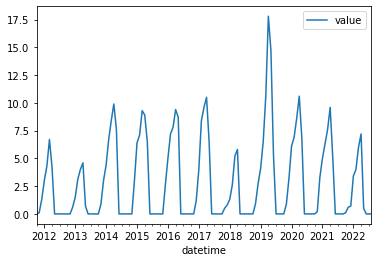

In [9]:
# simple plot to look at our data
ts.plot();

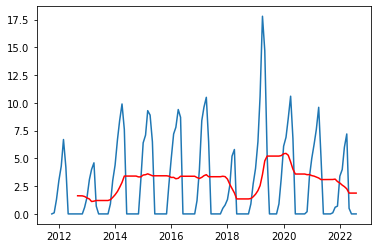

In [10]:
moving_avg = ts.rolling(period).mean()
plt.plot(ts)
plt.plot(moving_avg, color='red')

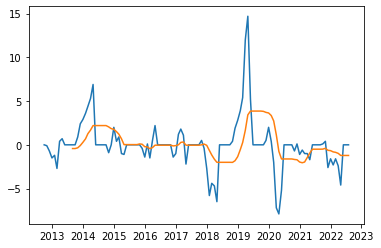

In [11]:
ts_diffs = ts - ts.shift(period)
ts_diffs.dropna(inplace=True)
plt.plot(ts_diffs)
plt.plot(ts_diffs.rolling(period).mean());

### Testing Stationarity

Here we will use a Dicky-Fuller test to evaluate the stationarity of our time series.

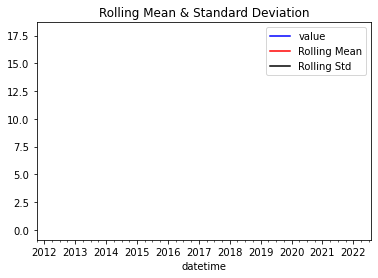

Results of Dickey-Fuller Test:
Test Statistic                  -2.681767
p-value                          0.077247
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [12]:
from src.scripts import test_stationarity

test_stationarity(ts, period)

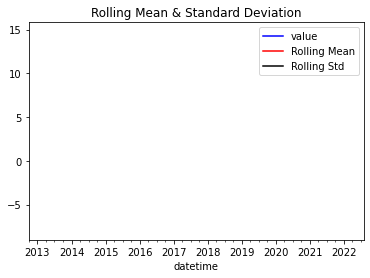

Results of Dickey-Fuller Test:
Test Statistic                  -4.782865
p-value                          0.000059
#Lags Used                      11.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [13]:
test_stationarity(ts_diffs, period)

There's clearly seasonality to this data, so lets go ahead and decompose the data into its trend, seasonality and residuals.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

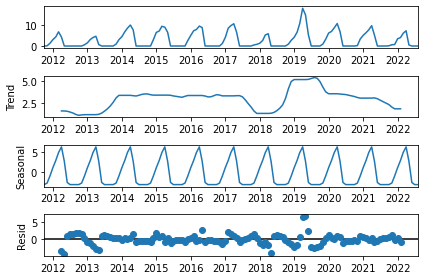

In [15]:
decomp.plot();

This decomp doesn't look very promising considering the seasonal and trend graphs. We'll attempt using the original data for the model and following predictive methods.

### Modeling Water Equivalent Values

We will construction 4 different models and compare between them:
- **AR**: Auto-Regressive model
- **MA**: Moving-Average model
- **ARIMA**: Auto-Regressive Integrated Moving Average model
- **SARIMAX**: Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

First, we have to determine our dependant parameters.
- **p**: Number of Auto-Regressive (AR) terms.
- **q**: Number of Moving-Average (MA) terms.
- **d**: Number of non-seasonal differences.
- **s**: Period of seasonality. Often 4 for quarterly data or 12 for monthly data. In this case 

Deterministic variables:
- **ACF**: measures correlation between two consecutive lags.
- **PACF**: measures cdegree of associate between y(t) and y(t-p).

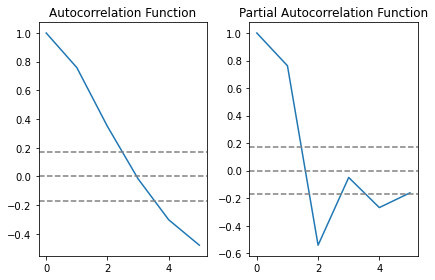

In [16]:
from statsmodels.tsa.arima.model import ARIMA

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

nlags=5

lag_acf = acf(ts, nlags=nlags)
lag_pacf = pacf(ts, nlags=nlags, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

Lets grab a few more Snotel sites to run these models on.

In [17]:
# Define an empty dictionary to store returns for each site
value_dict = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignore dataframe generation warnings
    for i, sitecode in enumerate(sites.index):
        print('%i of %i sites: %s' % (i+1, len(sites.index), sitecode))
        out = snotel_fetch(sitecode, 'SNOTEL:WTEQ_m', startdate, today)
        if out is not None:
            value_dict[sitecode] = out['value']

1 of 135 sites: SNOTEL:1030_CO_SNTL
2 of 135 sites: SNOTEL:305_CO_SNTL


Unable to fetch SNOTEL:WTEQ_m
3 of 135 sites: SNOTEL:8082_UT_SNTL


Unable to fetch SNOTEL:WTEQ_m
4 of 135 sites: SNOTEL:317_WY_SNTL
5 of 135 sites: SNOTEL:1061_CO_SNTL
6 of 135 sites: SNOTEL:1041_CO_SNTL
7 of 135 sites: SNOTEL:1143_AZ_SNTL
8 of 135 sites: SNOTEL:342_WY_SNTL
9 of 135 sites: SNOTEL:345_CO_SNTL
10 of 135 sites: SNOTEL:348_UT_SNTL
11 of 135 sites: SNOTEL:1185_CO_SNTL
12 of 135 sites: SNOTEL:1162_UT_SNTL
13 of 135 sites: SNOTEL:353_WY_SNTL
14 of 135 sites: SNOTEL:368_UT_SNTL
15 of 135 sites: SNOTEL:371_UT_SNTL
16 of 135 sites: SNOTEL:1192_UT_SNTL
17 of 135 sites: SNOTEL:1153_UT_SNTL
18 of 135 sites: SNOTEL:913_CO_SNTL
19 of 135 sites: SNOTEL:378_CO_SNTL
20 of 135 sites: SNOTEL:380_CO_SNTL
21 of 135 sites: SNOTEL:383_UT_SNTL
22 of 135 sites: SNOTEL:386_CO_SNTL
23 of 135 sites: SNOTEL:387_CO_SNTL
24 of 135 sites: SNOTEL:247_CO_SNTL


Unable to fetch SNOTEL:WTEQ_m
25 of 135 sites: SNOTEL:1101_CO_SNTL
26 of 135 sites: SNOTEL:396_UT_SNTL
27 of 135 sites: SNOTEL:409_CO_SNTL
28 of 135 sites: SNOTEL:904_CO_SNTL
29 of 135 sites: SNOTEL:415_CO_SNTL
30 of 135 sites: SNOTEL:1236_UT_SNTL
31 of 135 sites: SNOTEL:426_CO_SNTL
32 of 135 sites: SNOTEL:432_UT_SNTL
33 of 135 sites: SNOTEL:435_UT_SNTL
34 of 135 sites: SNOTEL:444_UT_SNTL
35 of 135 sites: SNOTEL:449_WY_SNTL
36 of 135 sites: SNOTEL:452_UT_SNTL
37 of 135 sites: SNOTEL:457_CO_SNTL
38 of 135 sites: SNOTEL:461_UT_SNTL
39 of 135 sites: SNOTEL:1163_UT_SNTL
40 of 135 sites: SNOTEL:465_CO_SNTL
41 of 135 sites: SNOTEL:467_CO_SNTL
42 of 135 sites: SNOTEL:468_WY_SNTL
43 of 135 sites: SNOTEL:1252_CO_SNTL
44 of 135 sites: SNOTEL:1120_CO_SNTL
45 of 135 sites: SNOTEL:1149_UT_SNTL
46 of 135 sites: SNOTEL:481_UT_SNTL
47 of 135 sites: SNOTEL:1186_CO_SNTL
48 of 135 sites: SNOTEL:505_CO_SNTL
49 of 135 sites: SNOTEL:248_CO_SNTL


Unable to fetch SNOTEL:WTEQ_m
50 of 135 sites: SNOTEL:509_WY_SNTL
51 of 135 sites: SNOTEL:521_UT_SNTL
52 of 135 sites: SNOTEL:522_UT_SNTL
53 of 135 sites: SNOTEL:1187_CO_SNTL
54 of 135 sites: SNOTEL:528_UT_SNTL
55 of 135 sites: SNOTEL:538_CO_SNTL
56 of 135 sites: SNOTEL:542_CO_SNTL
57 of 135 sites: SNOTEL:543_UT_SNTL
58 of 135 sites: SNOTEL:544_WY_SNTL
59 of 135 sites: SNOTEL:547_CO_SNTL
60 of 135 sites: SNOTEL:970_CO_SNTL
61 of 135 sites: SNOTEL:554_WY_SNTL
62 of 135 sites: SNOTEL:555_WY_SNTL
63 of 135 sites: SNOTEL:556_CO_SNTL
64 of 135 sites: SNOTEL:559_UT_SNTL
65 of 135 sites: SNOTEL:565_CO_SNTL
66 of 135 sites: SNOTEL:566_UT_SNTL
67 of 135 sites: SNOTEL:1116_UT_SNTL
68 of 135 sites: SNOTEL:513_UT_SNTL
69 of 135 sites: SNOTEL:572_UT_SNTL
70 of 135 sites: SNOTEL:1215_UT_SNTL
71 of 135 sites: SNOTEL:261_UT_SNTL


Unable to fetch SNOTEL:WTEQ_m
72 of 135 sites: SNOTEL:1047_WY_SNTL
73 of 135 sites: SNOTEL:586_CO_SNTL
74 of 135 sites: SNOTEL:589_CO_SNTL
75 of 135 sites: SNOTEL:1261_UT_SNTL
76 of 135 sites: SNOTEL:597_WY_SNTL
77 of 135 sites: SNOTEL:940_CO_SNTL
78 of 135 sites: SNOTEL:607_CO_SNTL
79 of 135 sites: SNOTEL:905_CO_SNTL
80 of 135 sites: SNOTEL:618_CO_SNTL
81 of 135 sites: SNOTEL:1040_CO_SNTL
82 of 135 sites: SNOTEL:622_CO_SNTL
83 of 135 sites: SNOTEL:1014_CO_SNTL
84 of 135 sites: SNOTEL:629_CO_SNTL
85 of 135 sites: SNOTEL:632_CO_SNTL
86 of 135 sites: SNOTEL:643_UT_SNTL
87 of 135 sites: SNOTEL:1269_UT_SNTL
88 of 135 sites: SNOTEL:658_CO_SNTL
89 of 135 sites: SNOTEL:1138_NM_SNTL
90 of 135 sites: SNOTEL:249_CO_SNTL


Unable to fetch SNOTEL:WTEQ_m
91 of 135 sites: SNOTEL:661_WY_SNTL
92 of 135 sites: SNOTEL:669_CO_SNTL
93 of 135 sites: SNOTEL:675_CO_SNTL
94 of 135 sites: SNOTEL:680_CO_SNTL
95 of 135 sites: SNOTEL:682_CO_SNTL
96 of 135 sites: SNOTEL:688_CO_SNTL
97 of 135 sites: SNOTEL:1133_WY_SNTL
98 of 135 sites: SNOTEL:701_CO_SNTL
99 of 135 sites: SNOTEL:709_CO_SNTL
100 of 135 sites: SNOTEL:713_CO_SNTL
101 of 135 sites: SNOTEL:714_UT_SNTL
102 of 135 sites: SNOTEL:717_CO_SNTL
103 of 135 sites: SNOTEL:720_UT_SNTL
104 of 135 sites: SNOTEL:732_WY_SNTL
105 of 135 sites: SNOTEL:737_CO_SNTL
106 of 135 sites: SNOTEL:739_CO_SNTL
107 of 135 sites: SNOTEL:742_UT_SNTL
108 of 135 sites: SNOTEL:1060_CO_SNTL
109 of 135 sites: SNOTEL:762_CO_SNTL
110 of 135 sites: SNOTEL:765_WY_SNTL
111 of 135 sites: SNOTEL:1117_UT_SNTL
112 of 135 sites: SNOTEL:779_WY_SNTL
113 of 135 sites: SNOTEL:780_CO_SNTL
114 of 135 sites: SNOTEL:790_UT_SNTL
115 of 135 sites: SNOTEL:793_CO_SNTL
116 of 135 sites: SNOTEL:795_UT_SNTL
117 of 135 sit

Unable to fetch SNOTEL:WTEQ_m
130 of 135 sites: SNOTEL:1188_CO_SNTL
131 of 135 sites: SNOTEL:1160_CO_SNTL
132 of 135 sites: SNOTEL:859_WY_SNTL
133 of 135 sites: SNOTEL:864_UT_SNTL
134 of 135 sites: SNOTEL:869_CO_SNTL
135 of 135 sites: SNOTEL:1228_UT_SNTL


### AR Model

In [22]:
from sklearn.metrics import mean_squared_error

# Train-test split: 80%-20% split.
cutoff = round(ts.shape[0]*0.8)
train = ts[:cutoff]
test = ts[cutoff:]

test.resample('M')
train.resample('M')

# Naive model, for comparison:
naive = train.shift(1).fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)
mean_squared_error(train, naive, squared=False)

# AR Model
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignore dataframe generation warnings
    model = ARIMA(train, order=(3, 0, 0))
    res = model.fit()
    print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  105
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -224.264
Date:                Wed, 03 Aug 2022   AIC                            458.529
Time:                        01:23:20   BIC                            471.799
Sample:                    10-01-2011   HQIC                           463.906
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9255      0.747      3.916      0.000       1.461       4.390
ar.L1          1.2023      0.088     13.656      0.000       1.030       1.375
ar.L2         -0.5530      0.158     -3.496      0.0

In [30]:
train['date'] = train.index
train.index = pd.to_datetime(train['date']).apply(lambda x: x.date())
train.drop(columns=['date'], inplace=True)

test['date'] = test.index
test.index = pd.to_datetime(test['date']).apply(lambda x: x.date())
test.drop(columns=['date'], inplace=True)

C:\Users\Mouse\AppData\Local\Temp\ipykernel_22172\794290242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = train.index
C:\Users\Mouse\AppData\Local\Temp\ipykernel_22172\794290242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=['date'], inplace=True)
C:\Users\Mouse\AppData\Local\Temp\ipykernel_22172\794290242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [36]:
history = train
history['date'] = history.index
history.index = pd.to_datetime(history['date']).apply(lambda x: x.date())
history.drop(columns=['date'], inplace=True)
predictions = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignore dataframe generation warnings
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(3,0,0), seasonal_order=(0,0,0,12))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test['value'][t]
        history.append(pd.DataFrame(index=[obs]))
        print('predicted=%f, expected=%f' % (yhat, obs))
        print(history.index.freq)
    
    # plot forecasts against actual outcomes
    x_predictions = pd.DataFrame(predictions)
    x_predictions = x_predictions.set_index(test.index)
    plt.plot(train, color='blue')
  #  plt.plot(test, color='green')
    plt.plot(history, color='gray')
    plt.plot(x_predictions, color='red')
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.title(f'Time Series Walk-Forward Validation')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    print(f'RMSE: {mean_squared_error(test, predictions, squared=False)}')

predicted=-2.932252, expected=0.000000


C:\Users\Mouse\AppData\Local\Temp\ipykernel_22172\3674679160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['date'] = history.index
C:\Users\Mouse\AppData\Local\Temp\ipykernel_22172\3674679160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history.drop(columns=['date'], inplace=True)


AttributeError: 'Index' object has no attribute 'freq'

In [38]:
history.index.freq

AttributeError: 'Index' object has no attribute 'freq'

In [20]:
from src.scripts import Multi_ARIMA

mean_RMSE = Multi_ARIMA(value_dict, order=(3,0,0), plot=False)
print(mean_RMSE)

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\bas

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scripts.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history.append(pd.DataFrame(index=[obs]))
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\Mouse\Desktop\Classwork\2022\GIS-2164-43599\Project\Python\src\scri

KeyboardInterrupt: 

The **ARIMA** model did best with the lowest RSS, we can now move on to running predictions.